In [2]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import h5py

sns.set_style('whitegrid')

sns.set_context('notebook')

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
%load_ext autoreload
%autoreload 2

root = '/home/ubuntu/ext_vol'
import sys
sys.path.insert(0, f'{root}/inpca')

from utils import get_data, get_idx, triplot, plotly_3d, load_d, dinpca, dbhat, plotly_3d
from utils.embed import proj_, lazy_embed
from reparameterization import v0

In [3]:
import plotly.graph_objects as go
import numpy as np
import plotly.offline as pyo
import pandas as pd
pyo.init_notebook_mode()
from matplotlib.lines import Line2D    
from utils import CDICT_M

In [9]:
all_f = glob.glob('/home/ubuntu/ext_vol/inpca/results/models/loaded/*.p')
fs = np.random.permutation(all_f)[:30]
d = load_d(fs, avg_err=True)

100%|███████████████████████████████████████████| 30/30 [00:58<00:00,  1.94s/it]


In [10]:
yhs = np.stack(d.yh)
if (yhs<0).any():
    yhs = np.exp(yhs)

cols = ["seed", "m", "opt", "bs", "aug", "lr", "wd"]
yhs_ = np.stack([yhs[list(ii[:10])+list(ii[-10:]), :] for ii in d.groupby(cols).indices.values()])

In [11]:
g = th.load('/home/ubuntu/ext_vol/inpca/results/models/loaded/{"seed":0,"bseed":-1,"aug":"na","m":"geodesic","bn":"na","drop":"na","opt":"geodesic","bs":"na","lr":"na","wd":"na","interp":false}.p')
geod = np.stack(g.yh)[::2, :, :]
p0 = geod[0, :]
ps = geod[-1, :]

In [4]:
import scipy.linalg as sp
def num_deriv(yhs, center=5, win=5):
    # yhs = [num_models, num_times, num_samples, num_classes]
    yhs = yhs[:, center-win:center+win+1, :,:]
    tan = (yhs[:, 2*win:win:-1, :, :] - yhs[:, :win, :, :])

    tan = tan/np.arange(win*2,0,-2)[None, :,None,None]
    return tan.sum(1) / (win-1)

def sph_interp(init, tan, ts):
    pts = np.stack([np.sqrt(init)+t*tan for t in ts])
    pts = pts ** 2
    pts /= pts.sum(-1, keepdims=True)
    return pts

def lin_interp(init, tan, ts):
    pts = np.stack([init+t*tan for t in ts])
    pts = np.abs(pts)
    pts /= pts.sum(-1, keepdims=True)
    return pts

def avg_v0(p, q, center=0, win=5):
    # p is a fixed point, shape=(num_models, 1, num_samples, num_classes)
    # q.shape = (num_models, num_t, num_samples, num_classes)
    vt = np.stack([v0(p, q[:, center+i, :]) for i in range(win)])
    return vt.mean(0)

def embed_(dists):
    dmean = dists.mean(0)
    l = np.eye(dists.shape[0]) - 1.0 / dists.shape[0]
    dists = -l @ dists @ l / 2
    e, v = sp.eigh(
        dists, driver="evx", check_finite=False
    )

    ii = np.argsort(np.abs(e))[::-1]
    e, v = e[ii], v[:, ii]
    xp = v * np.sqrt(np.abs(e))
    
    return dict(xp=xp, e=e, v=v, fn=np.sqrt((dists**2).sum()))

def get_all_tans(yhs_, p0, ps, it=40, et=40):
    # sampling tangent vectors on sphere
    nmodels, T, _, _ = yhs_.shape
    vinit = avg_v0(
               p=np.sqrt(np.tile(p0[None, :, :], [nmodels, 1, 1])),
               q=np.sqrt(yhs_), center=5, win=4
              )
    vinit_avg = vinit.mean(0)
    vinit_avg /= np.linalg.norm(vinit_avg)
    init_tan = sph_interp(p0, vinit_avg, ts=np.arange(it)).squeeze()

    vend = avg_v0(p=np.sqrt(np.tile(ps[None, :, :], [nmodels, 1, 1])),
                   q=np.sqrt(yhs_), center=T-15, win=5
                  )
    vend_avg = vend.mean(0)
    vend_avg /= np.linalg.norm(vend_avg)
    end_tan = sph_interp(ps, -vend_avg, ts=np.arange(et)).squeeze()
    return init_tan, end_tan

In [7]:
it, et = 50, 50
ne = 5
init_tan, end_tan = get_all_tans(yhs_, p0, ps, it, et)

In [8]:
all_points = th.tensor(np.vstack([init_tan, geod, end_tan]))

In [13]:
dists = dbhat(th.tensor(yhs), th.tensor(yhs), chunks=1000)
dmean = dists.mean(0)

In [14]:
r = embed_(dists)

In [16]:
i=5
b = r['v'][:, :i] @ np.diag(r['e'][:i]) @ r['v'][:, :i].T

In [18]:
np.diag(b)

array([0.38651811, 0.38454385, 0.14729021, ..., 0.27496135, 0.27523323,
       0.27425546])

In [25]:
((r['v'][:, :i]**2) * r['e'][:i]).sum(-1)

array([0.38651811, 0.38454385, 0.14729021, ..., 0.27496135, 0.27523323,
       0.27425546])

In [20]:
i = 5
dr = dinpca(th.tensor(r['xp'][:, :i]), 
            th.tensor(r['xp'][:, :i]),
            sign=th.tensor(np.sign(r['e'][:i])).double()).cpu().numpy()

In [28]:
l = np.eye(dists.shape[0]) - 1.0 / dists.shape[0]
B = -l @ dists @ l / 2

In [5]:
r = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p')

In [6]:
dfs = []
b = r['diag']
n = len(b)
trb = np.sum(b)
dfnorm = 2*trb**2 + 2*n*np.linalg.norm(b)**2+4*r['fn']

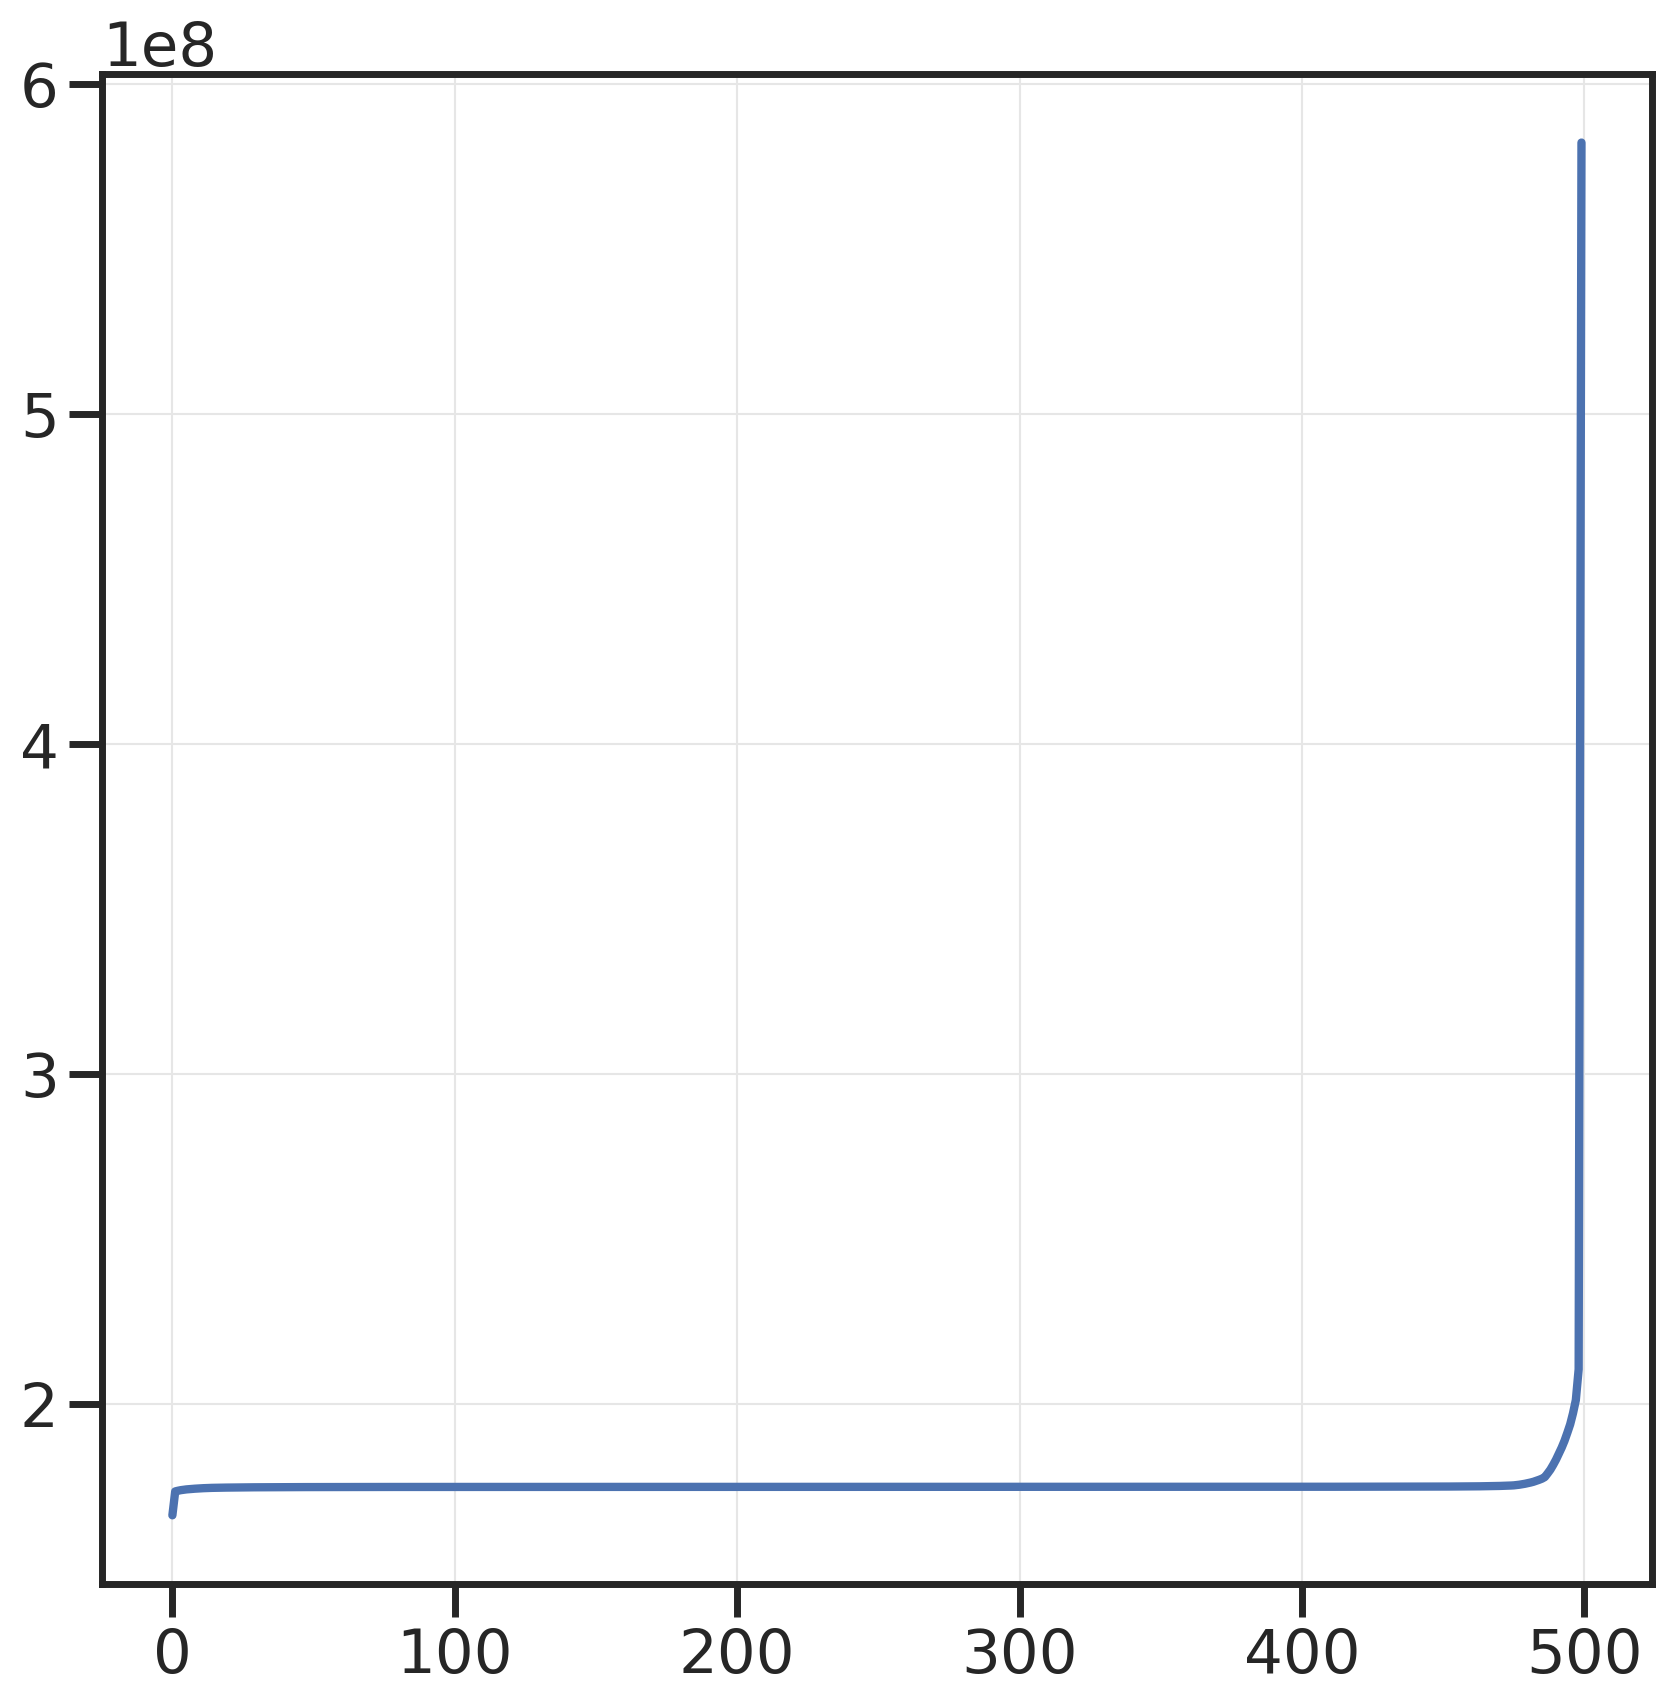

In [23]:
ii = np.argsort((np.abs(r['es'])))[::-1]

In [24]:
es = r['es'][ii]
vs = r['vs'][:, ii]

In [25]:
vs.shape

(151507, 500)

In [26]:
dfs = []
for i in range(1,501):
    t1 = 2*(trb - es[:i].sum())**2
    bk = ((vs[:, :i]**2) * es[:i]).sum(-1)
    t2 = 2*n*np.linalg.norm(b - bk)**2
    t3 = 4*(r['fn'] - (es[:i]**2).sum())
    dfs.append(dict(dim=i, t1=t1, t2=t2, t3=t3, err=1-np.sqrt((t1+t2+t3) / dfnorm)))

In [27]:
dfs = pd.DataFrame(dfs)
dfs['sign'] = np.sign(es)

In [28]:
dfs = dfs.melt(id_vars=['dim', 'sign'], value_vars=['t1', 't2', 't3','err'])

<AxesSubplot:xlabel='dim', ylabel='value'>

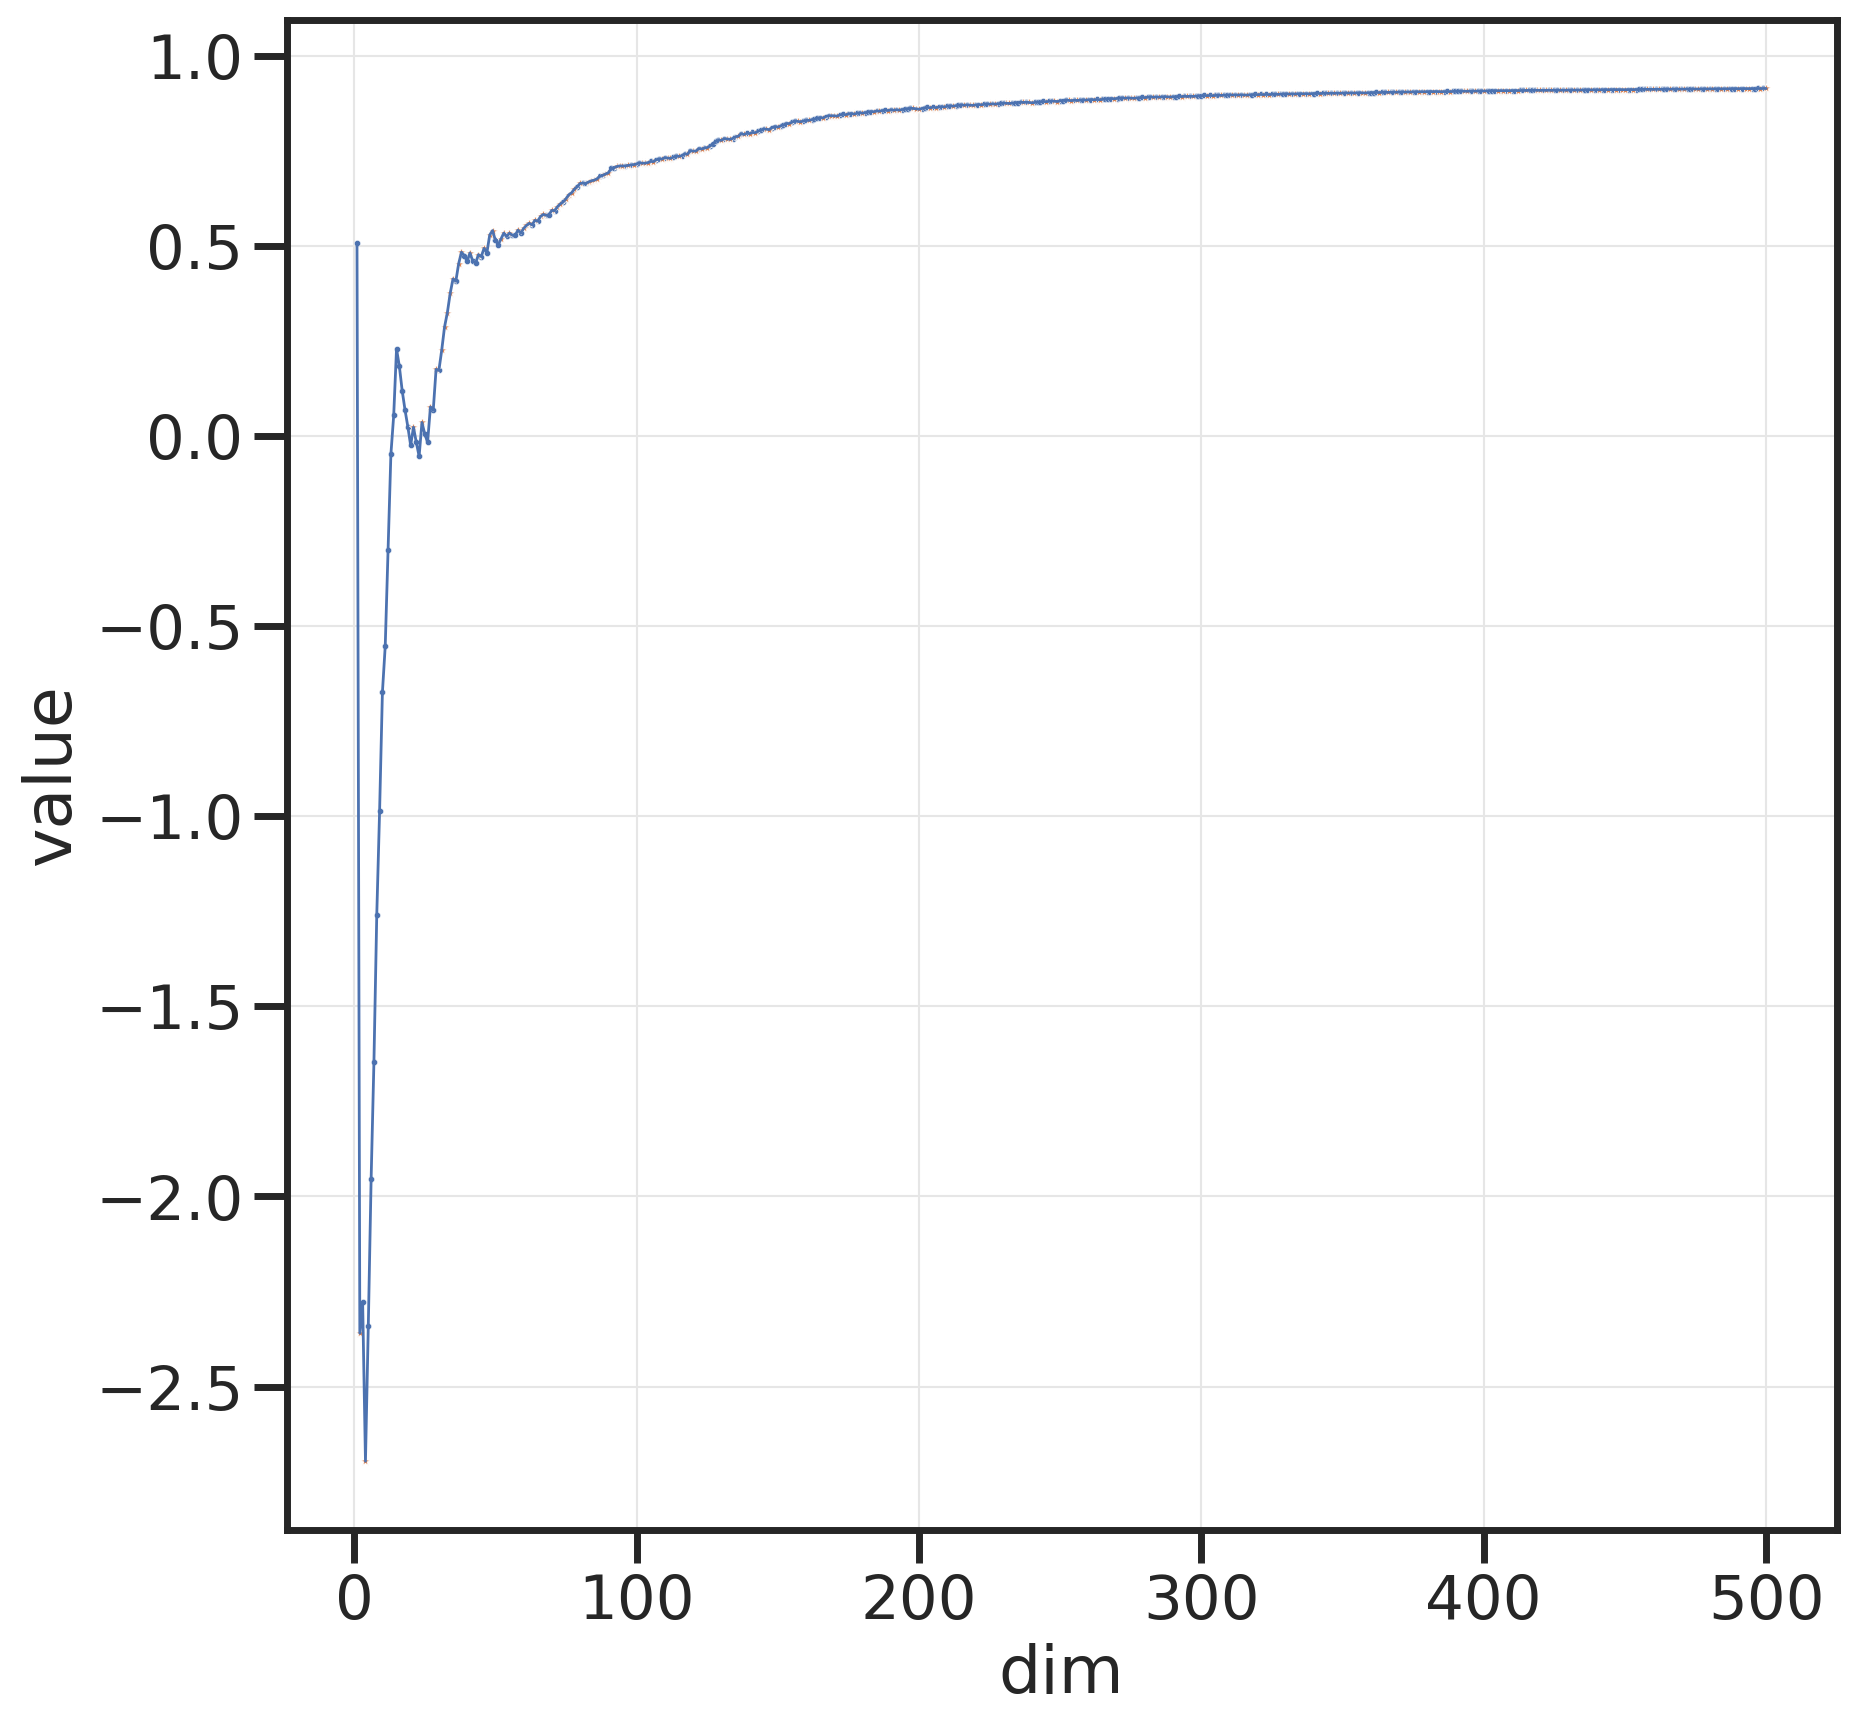

In [29]:
ax = sns.lineplot(data=dfs[dfs.variable=='err'], x='dim', y='value', lw=1)
sns.scatterplot(data=dfs[(dfs.variable=='err')&(dfs.sign==1)], x='dim', y='value', marker='o', ax=ax, s=5)
sns.scatterplot(data=dfs[(dfs.variable=='err')&(dfs.sign==-1)], x='dim', y='value', marker='*', ax=ax, s=12)

In [105]:
rtrue = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p')
n = rtrue['xp'].shape[0]
rel_err = []
for i in range(1, 6):
    wsum = 0
    true_err = 0
    tan_err = 0
    for aa in tqdm.tqdm(th.chunk(th.arange(n), 20)):
        for bb in th.chunk(th.arange(n), 20):
            dtrue = dinpca(th.tensor(rtrue['xp'][aa, :i]), 
                            th.tensor(rtrue['xp'][bb, :i]),
                            sign=th.tensor(np.sign(rtrue['e'][:i])).double()).cpu().numpy()
            with h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all_geod.h5', 'r') as f:
                w = f['w'][list(aa), :][:, list(bb)]
            true_err += ((dtrue.T-w)**2).sum()
            wsum += (w**2).sum()
    rel_err.append([np.sqrt(true_err/wsum)])


100%|███████████████████████████████████████████| 20/20 [12:27<00:00, 37.40s/it]


In [108]:
1-np.array(rel_err)

array([[ 0.5067068 ],
       [-2.35886321],
       [-2.27782445],
       [-2.69567284],
       [-2.34089563]])

In [14]:
dfs

dim  sign variable         value
0       1   1.0       t1  1.943878e+08
1       2   1.0       t1  9.265556e+07
2       3   1.0       t1  4.624323e+07
3       4   1.0       t1  1.774509e+07
4       5   1.0       t1  3.825324e+06
...   ...   ...      ...           ...
1995  496  -1.0      err -2.928771e+00
1996  497  -1.0      err -2.870599e+00
1997  498  -1.0      err -2.834484e+00
1998  499  -1.0      err -2.387648e+00
1999  500  -1.0      err  9.139280e-01

[2000 rows x 4 columns]

<AxesSubplot:xlabel='dim', ylabel='value'>

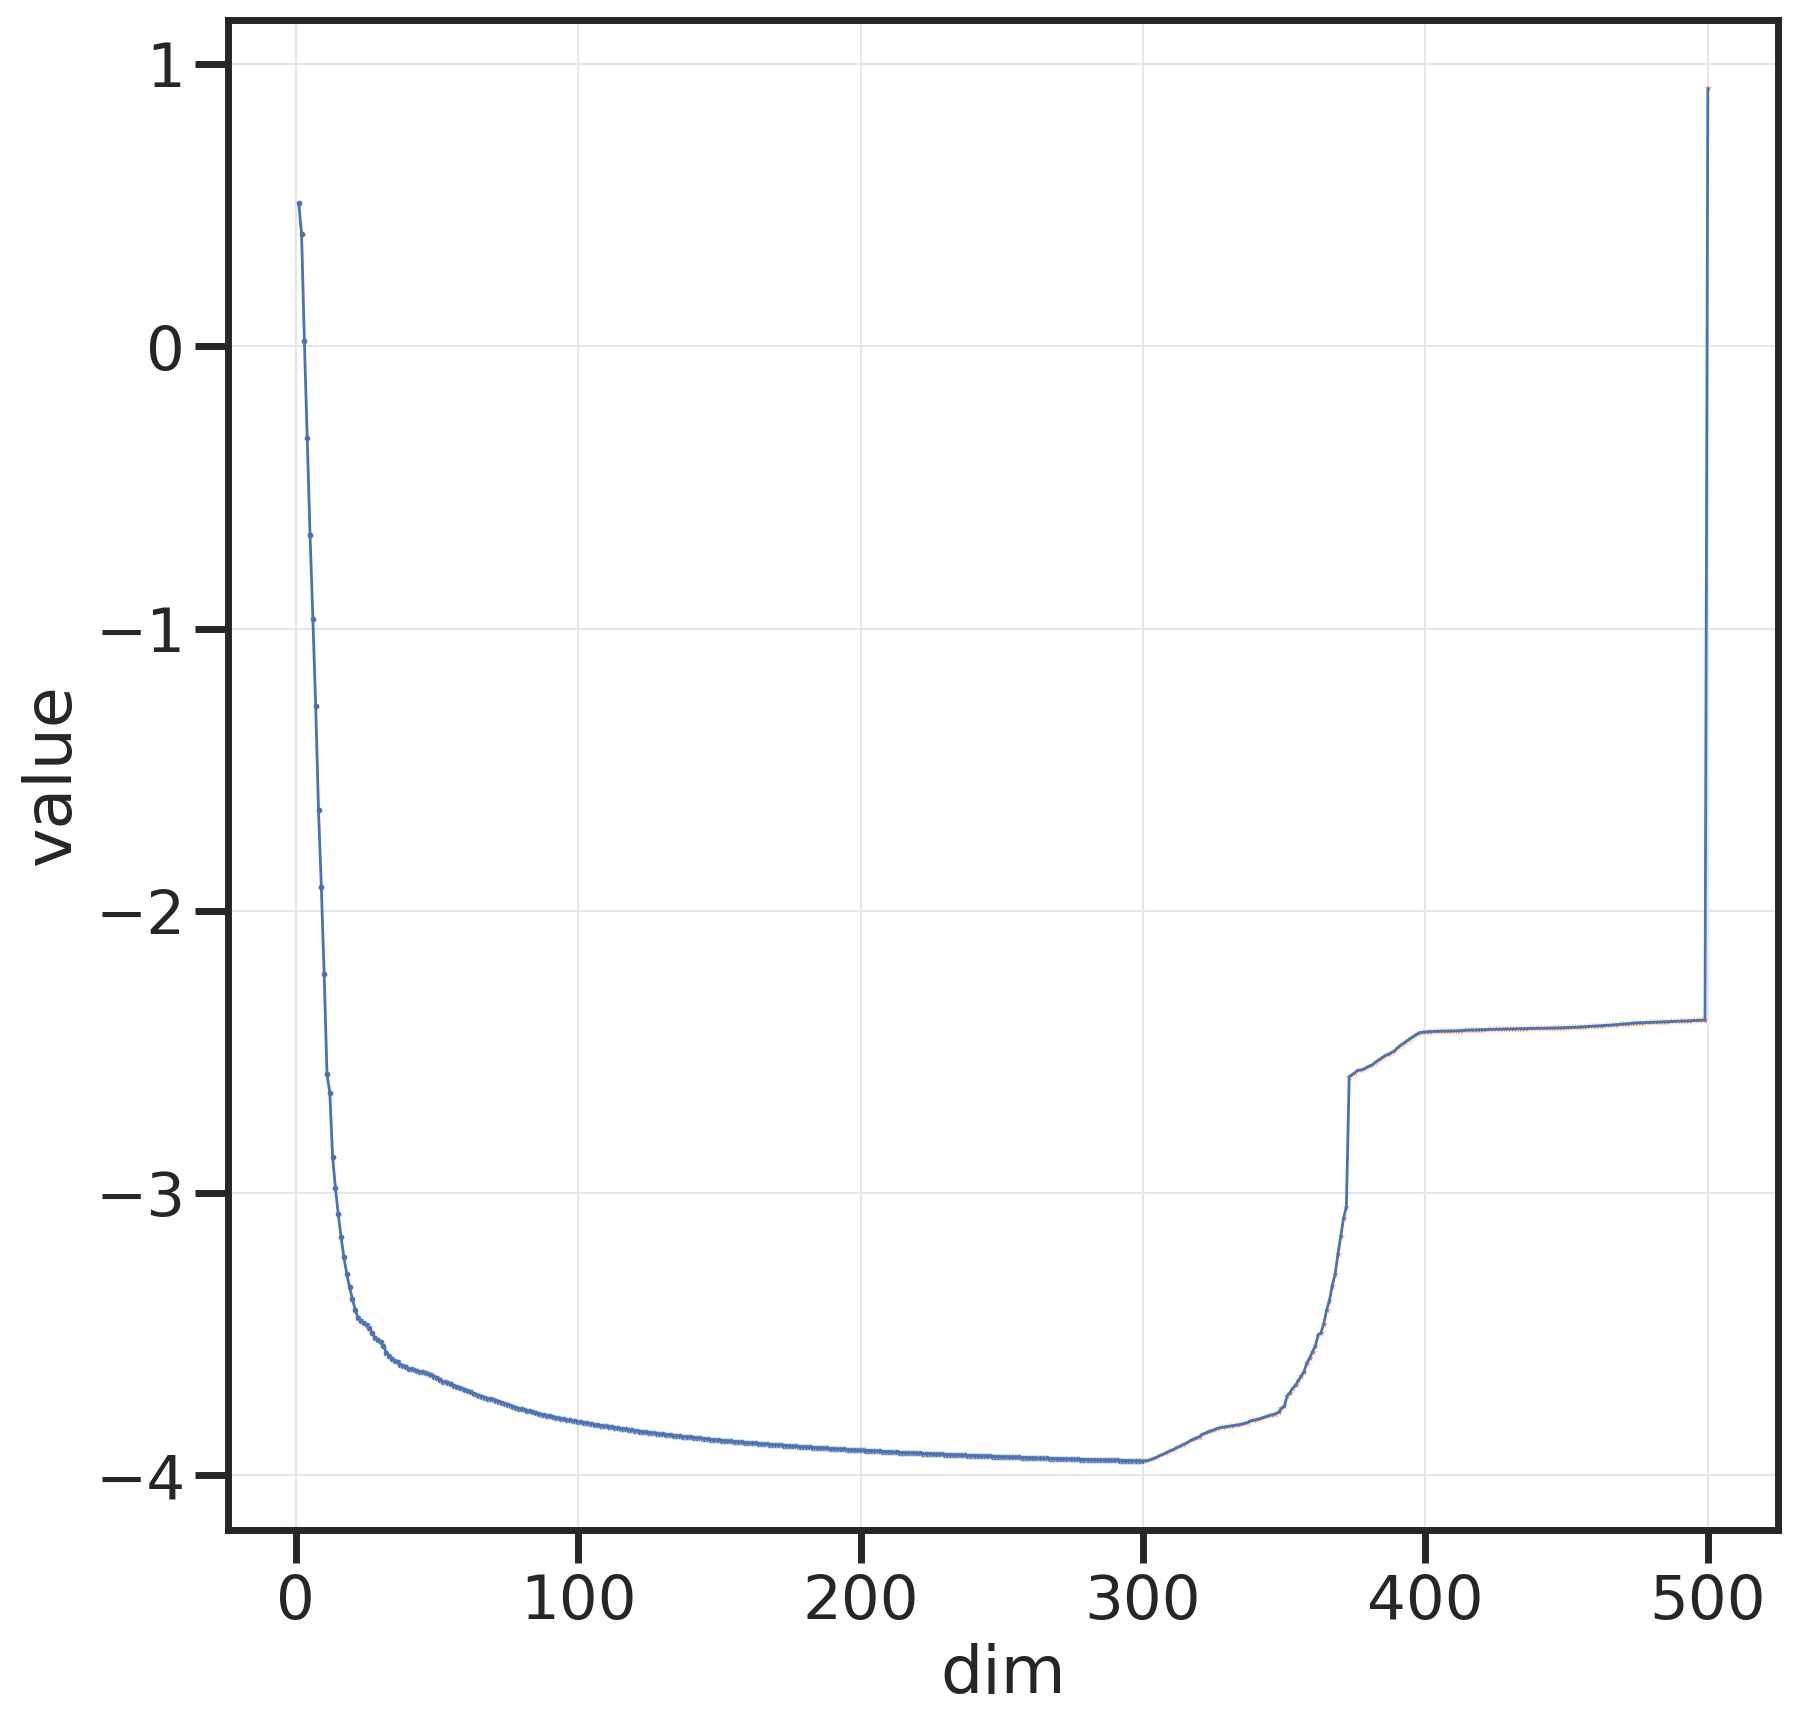

In [22]:
ax = sns.lineplot(data=dfs[dfs.variable=='err'], x='dim', y='value', lw=1)
sns.scatterplot(data=dfs[(dfs.variable=='err')&(dfs.sign==1)], x='dim', y='value', marker='o', ax=ax, s=5)
sns.scatterplot(data=dfs[(dfs.variable=='err')&(dfs.sign==-1)], x='dim', y='value', marker='*', ax=ax, s=12)

[None]

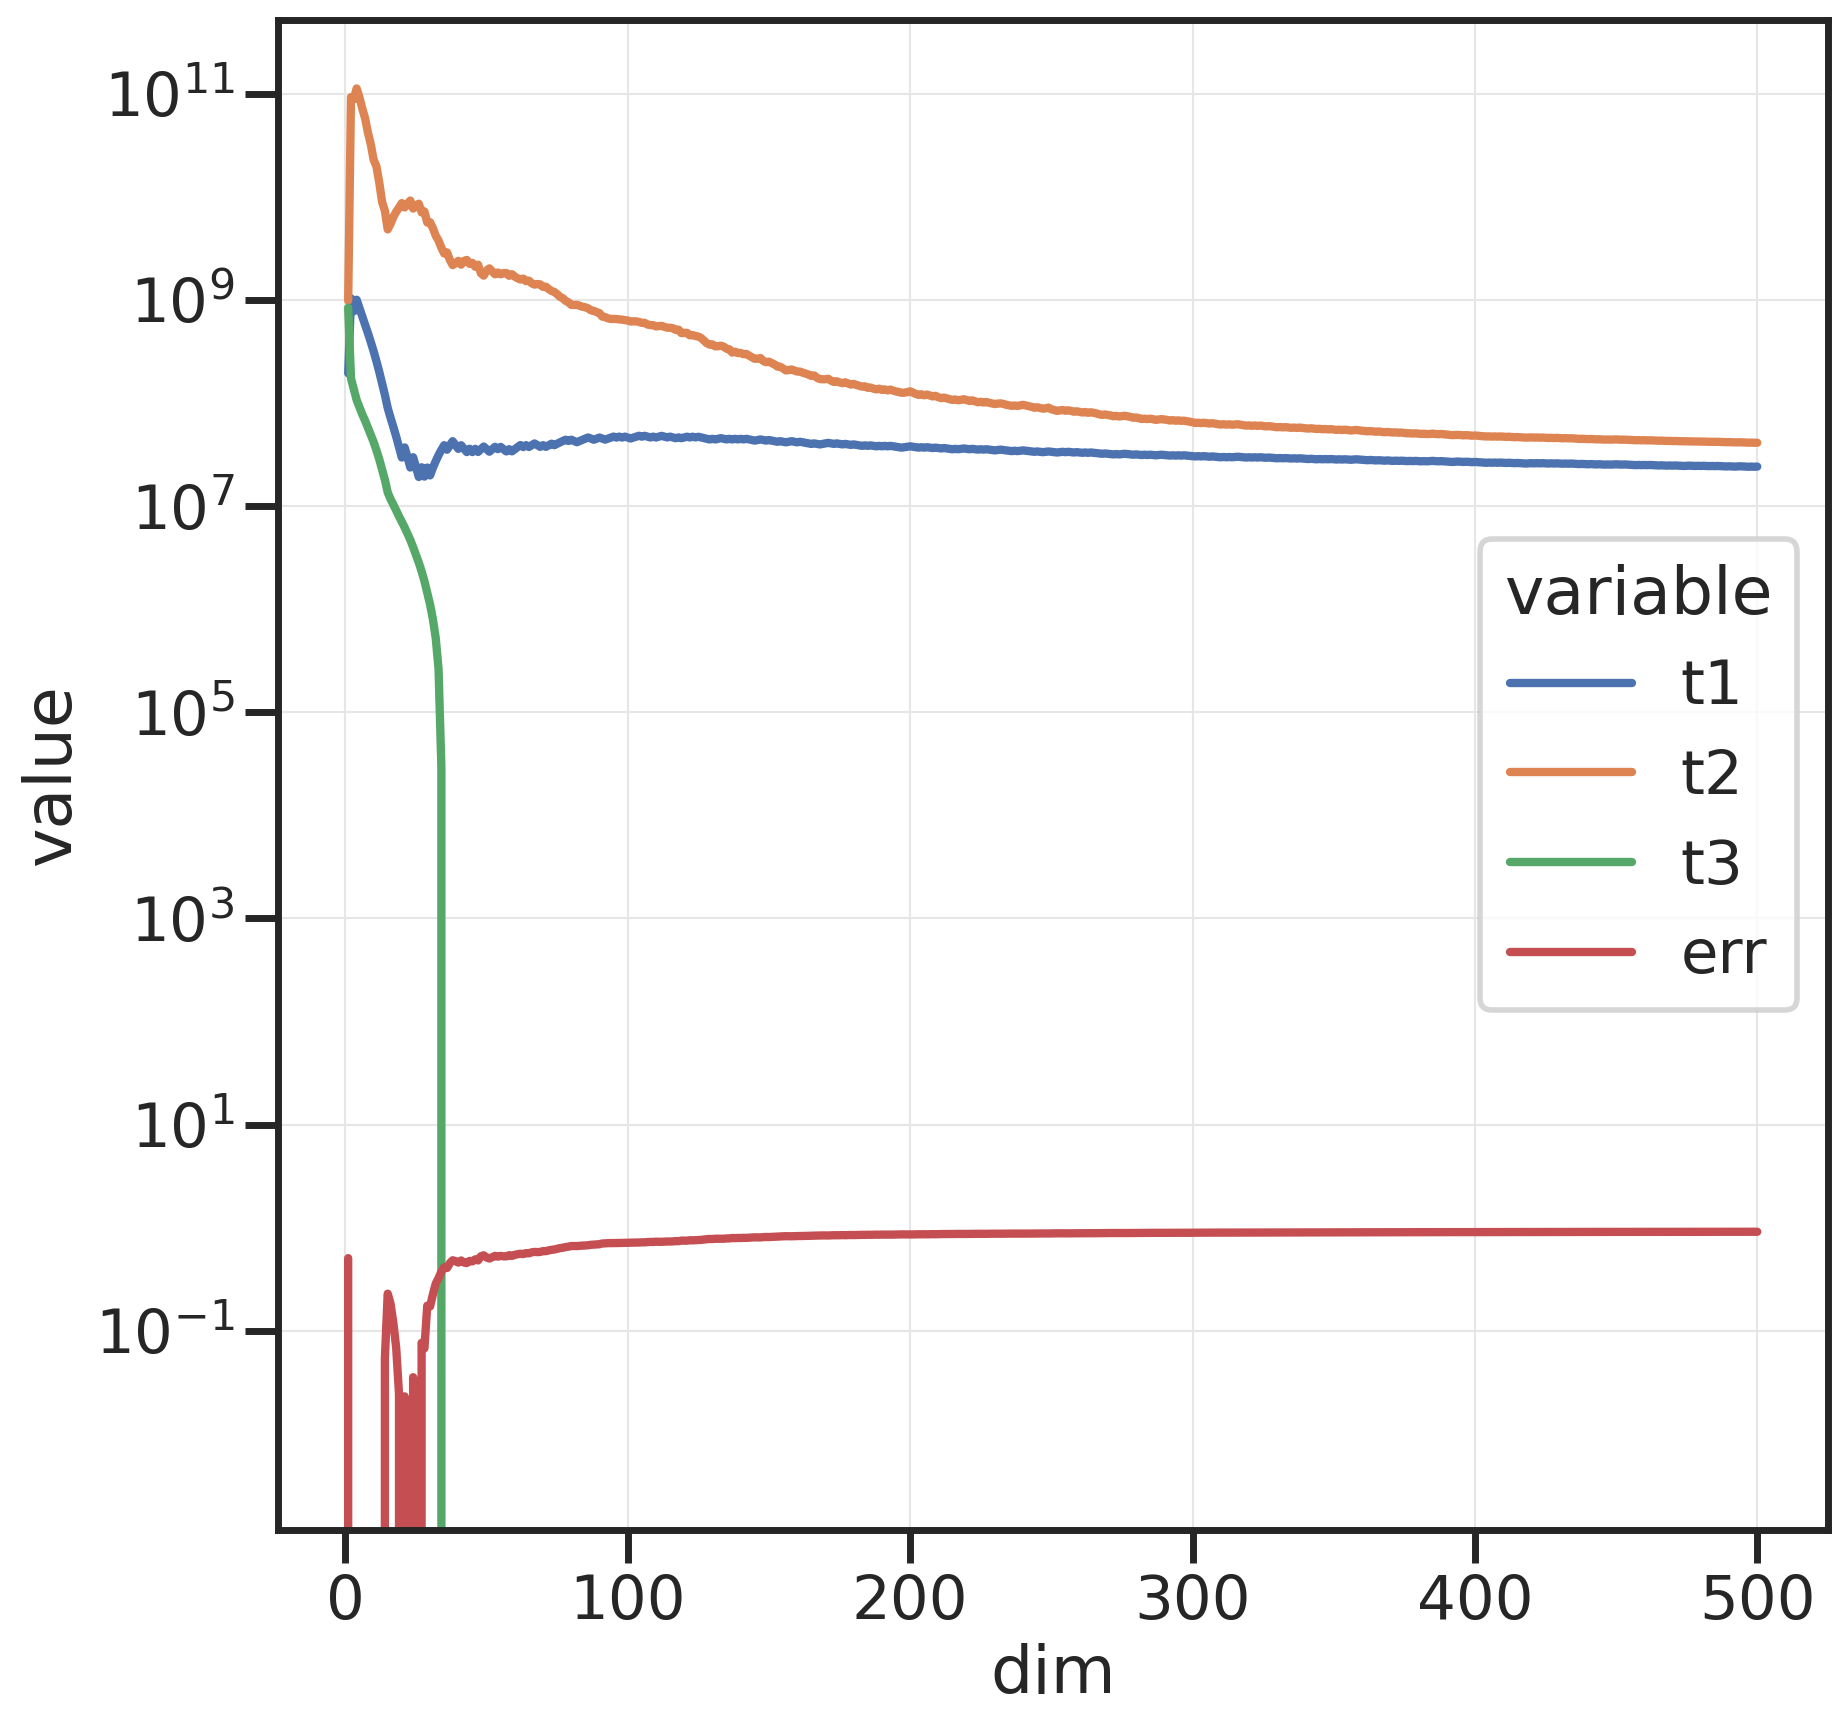

In [34]:
ax=sns.lineplot(data=dfs, x='dim', y='value', hue='variable')
ax.set(yscale='log')

In [41]:
drs = []
for i in range(150):
    dr = dinpca(th.tensor(r['xp'][:, :i]), 
            th.tensor(r['xp'][:, :i]),
            sign=th.tensor(np.sign(r['e'][:i])).double()).cpu().numpy()
    drs.append(1-np.sqrt(((dists-dr)**2).sum() / (dists**2).sum()))

[None, (0.1, 1)]

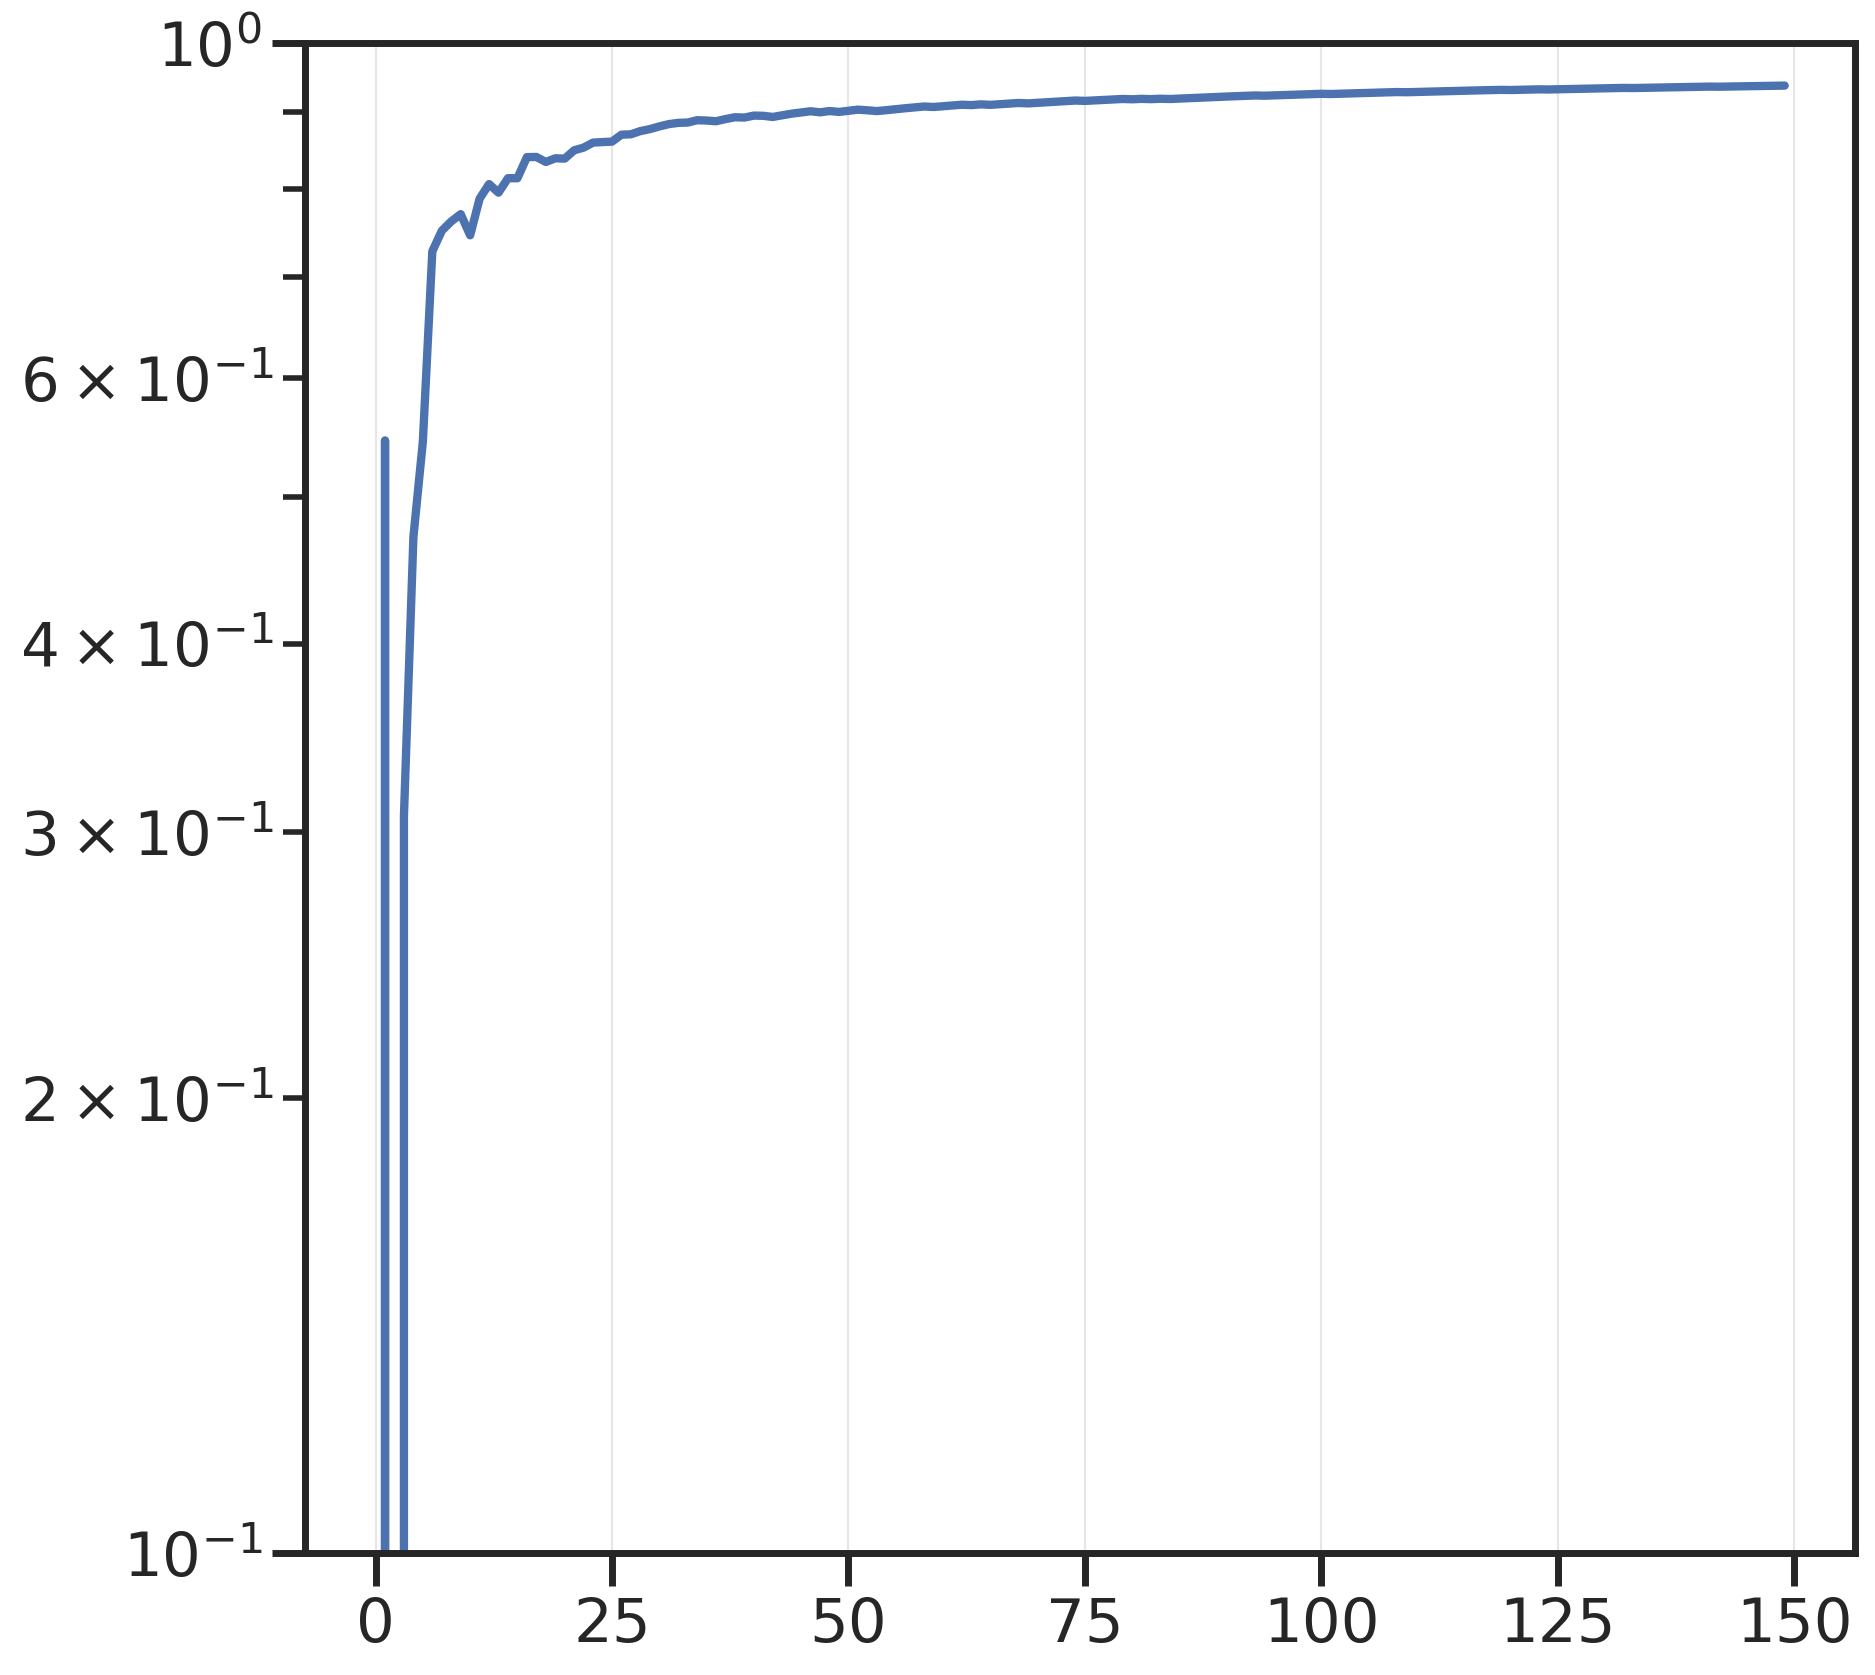

In [12]:
ax=sns.lineplot(x=np.arange(150), y=drs)
ax.set(yscale='log', ylim=[0.1, 1])

[None, (0.1, 1)]

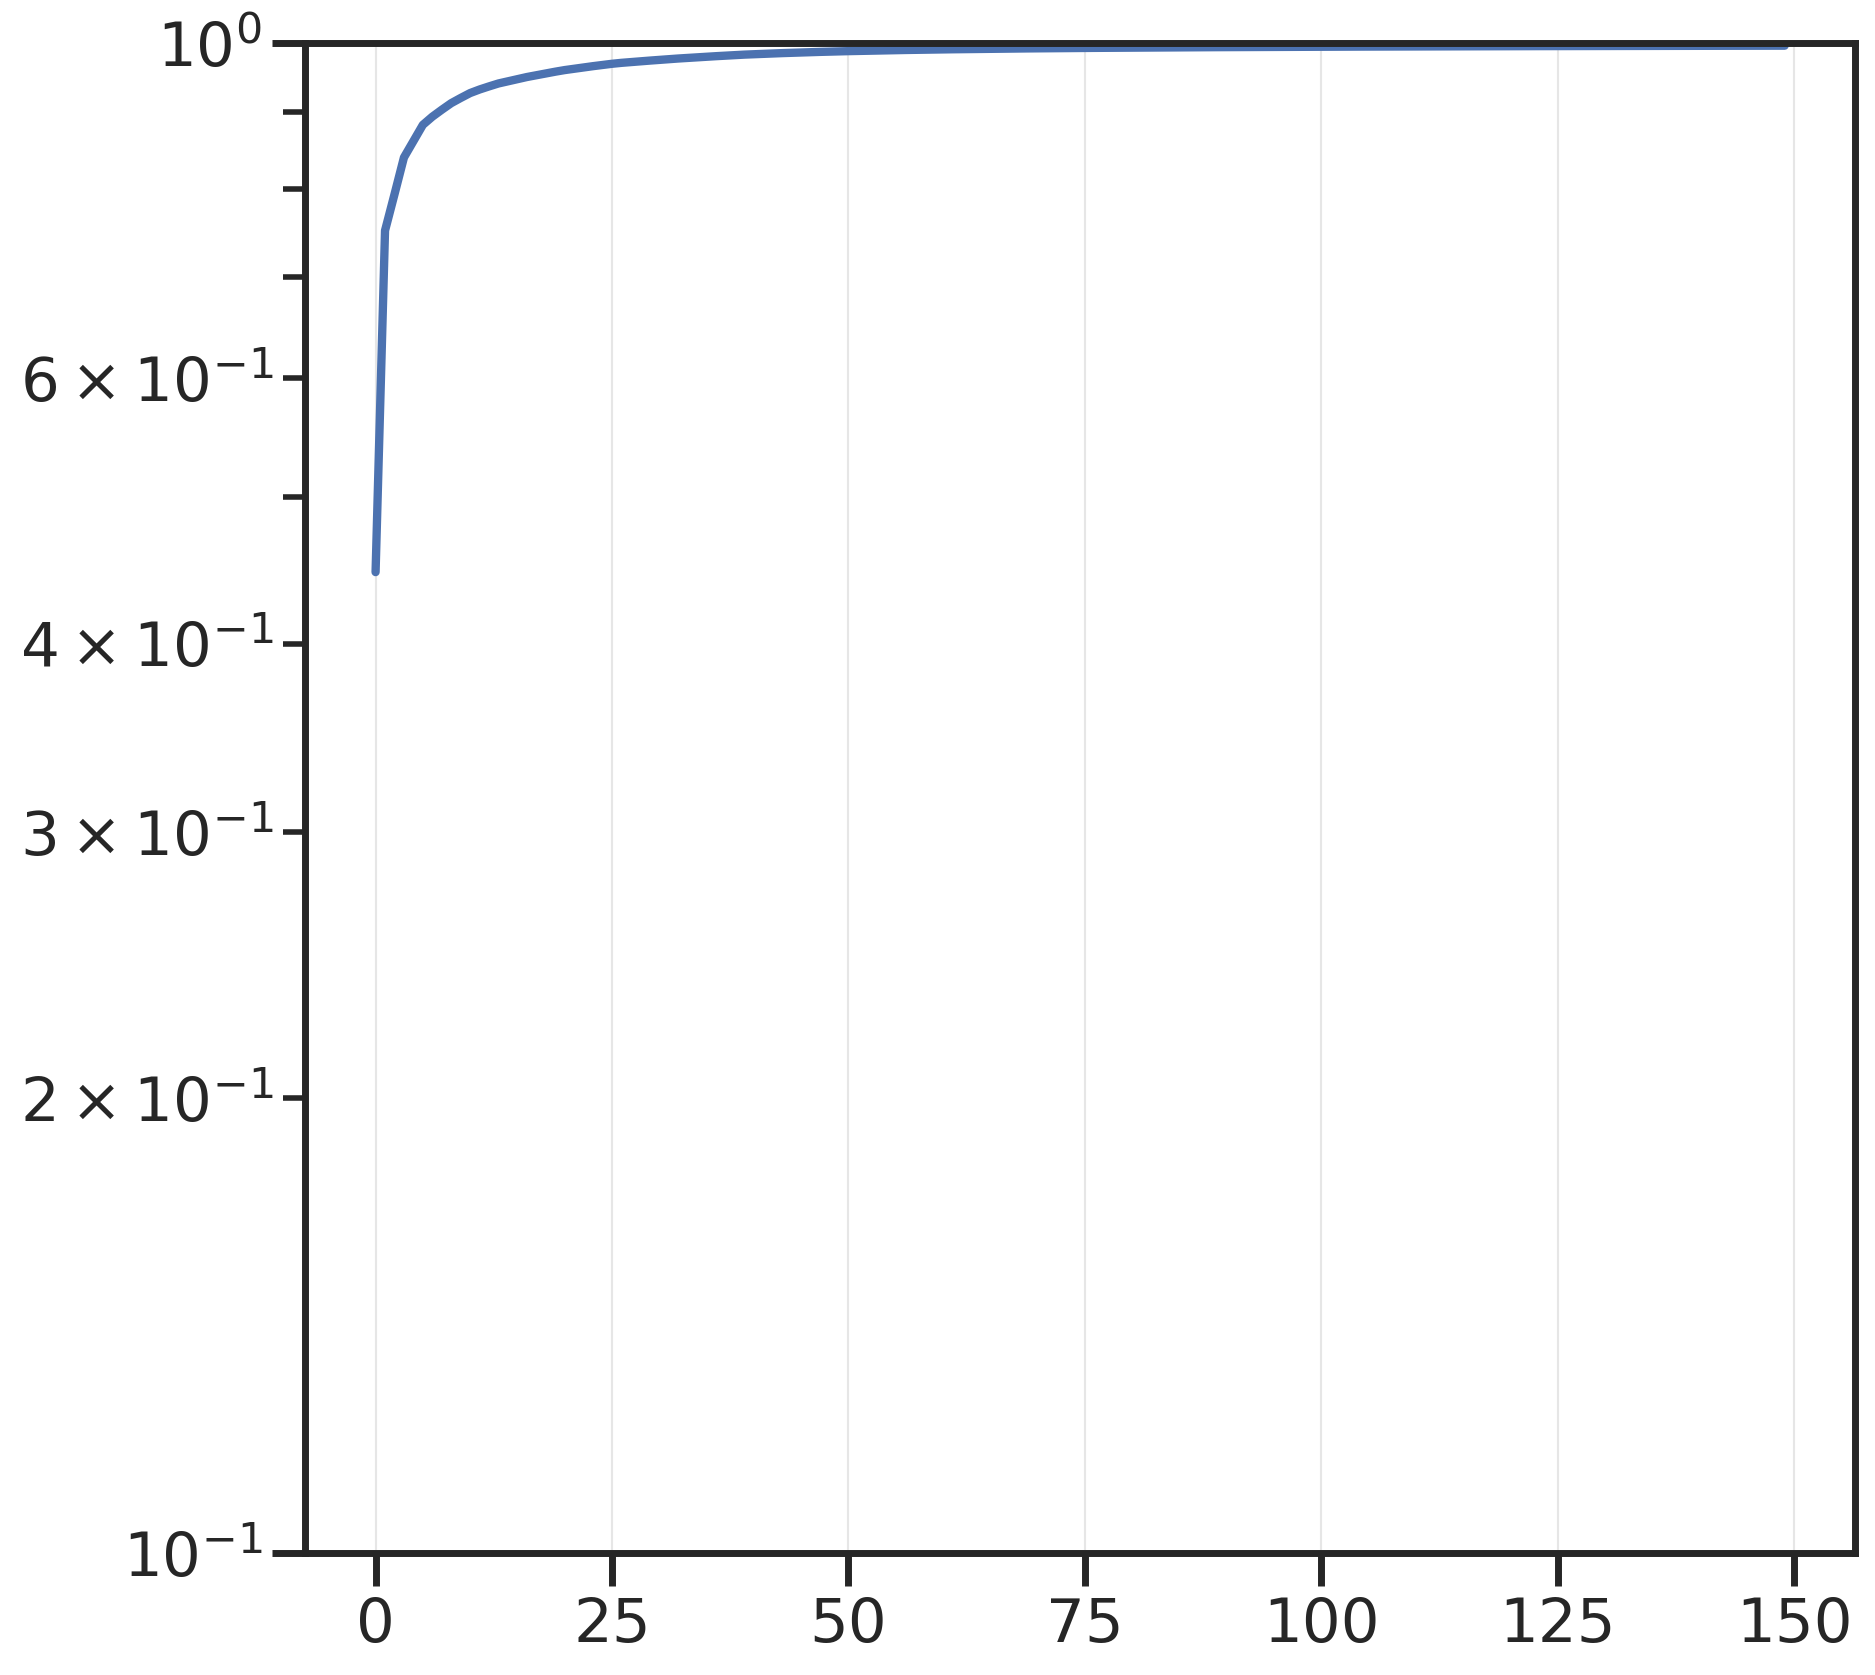

In [15]:
ax=sns.lineplot(x=np.arange(150), y=1 - np.sqrt(np.abs(1-np.cumsum(r['e'][:150] ** 2)/r['fn']**2)))
ax.set(yscale='log', ylim=[0.1, 1])

In [ ]:
for i in range(150):
    dr = dinpca(th.tensor(r['xp'][:, :i]), 
            th.tensor(r['xp'][:, :i]),
            sign=th.tensor(np.sign(r['e'][:i])).double()).cpu().numpy()
    drs.append(1-np.sqrt(((dists-dr)**2).sum() / (dists**2).sum()))